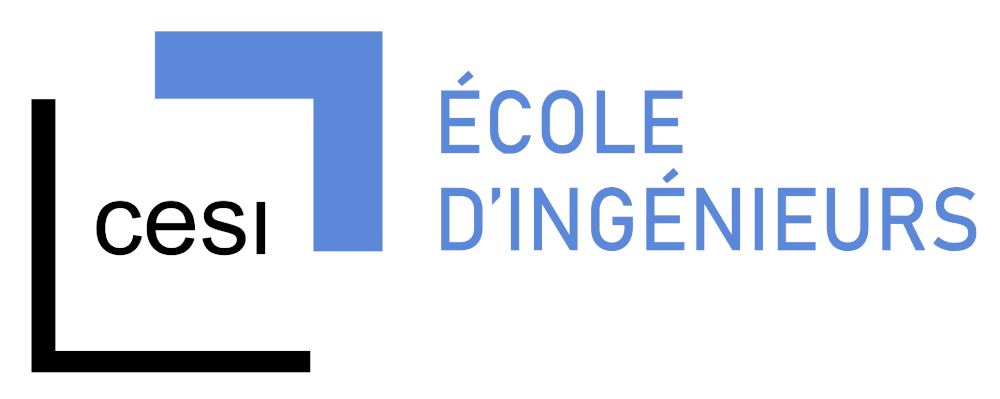

<h1 align='center'>Projet Leyenda - Livrable 2 - Traitement d'images</h1>
<h3 align='center'>Rima Benrejeb, Thomas Mattone, Bastien Reynaud, Badreddine Ferragh</h1>

## **Table Of Contents**
> 1. [Objective](#1)
> 2. [Libraries Import](#2)
> 3. [Hyperparameter initialization ](#3)
> 4. [Data Preparation](#4)
>> 4.1. [Data Augmentation](#4_1) 
>> 4.2. [Data Noising](#4_2)
>> 4.3. [Data Normalisation](#4_3)
> 5. [Original Vs. Noisy images](#5)
> 7. [Convolutional Neural Networks](#7)
> 8. [Improving models](#8)
> 9. [Improving training](#9)
> 10. [Transfer Learning](#10)
> 11. [Results](#11)

## Objective <a class="anchor" id="1"></a> 

This notebook presents our implementation of encoding architechures using Deep Learning.

In the previous part we classified photos and other images through CNN models. In this notebook we will discuss the denoising of photos using algorithms relied on <b>convolution auto-encoders</b> in order to facilitate their processing.


## Libraries Import <a class="anchor" id="2"></a>

First, we will import all the libraries necessary for our denoising:

<b>Keras</b>, the Keras library enables interaction with deep neural network and machine learning algorithms, including Tensorflow.

<b>Tensorflow</b>, TensorFlow is an open-source machine learning tool developed by Google.

<b>Numpy</b>, NumPy is a library for Python programming language, intended to manipulate matrices or multidimensional arrays as well as mathematical functions operating on these arrays.

<b>Matplotlib</b>, is a library used to plot and visualize data using graphs.

<b>Scikit-Learn</b>, is a library used for machine learning and metrics analysis

In [35]:
# %load_ext watermark

import warnings
warnings.filterwarnings("ignore")

# File manipulation
import os
import pathlib
import shutil
import wget
import zipfile

# Data manipulation
import numpy as np

# Machine Learning
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Input, Flatten, MaxPool2D, ReLU, Reshape, UpSampling2D
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa

tf.random.set_seed(1234)

# Image manipulation
import imghdr
from PIL import ImageFile

# Options for PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras 

# Options for seaborn
sns.set_style('darkgrid')
%matplotlib inline

# Utils
import leyenda_utils as lu
# %watermark -p watermark,wget,numpy,sklearn,tensorflow,tensorflow_hub,PIL,matplotlib,seaborn,visualkeras

## Hyperparameter initialization  <a class="anchor" id="3"></a>
These parameters we will used throughout our notebook:
>**BATCH_SIZE** : This variable is the batch size which defines the number of samples that will be propagated through the network.
>
>**VALIDATION_SPLIT** : It is a way to predict the fit of a model to a hypothetical test set when an explicit test set is not available\n",
>
>**EPOCHS** : An epoch refers to one cycle through the full training data set.
>
>**NOISE_FACTOR** : It is the noise factor that will define whether our image will be highly noisy or not.

Then we define the directory path to the dataset and our model backups.

In [74]:
# Defining Directories 
PATH_MODEL_SAVE = ...
DATA_PATH = '../../../tun21/Df/liv2/noise' # YOU CAN CHANGE IT WITH YOUR PATH  

NOISE_FACTOR = 0.2
IMG_H, IMG_W = 180, 180
BATCH_SIZE = 9
VALIDATION_SPLIT = 0.2


## 4. Data Preparation <a class="anchor" id="4"></a>

To prepare the dataset, we thought about increasing the size of our dataset since it initially has 150 images.
Therefore, this will allow us to improve the performance of our models

Even if the dataset is already clean, we run a quick verification of all the images.

In [75]:
data_dir = pathlib.Path(os.path.join(DATA_PATH))
invalid_images = []

for file in list(data_dir.glob('*/*.*')):
    if imghdr.what(file) not in ['jpeg', 'png']:
        invalid_images.append(file)
        
print(f'{len(invalid_images)} invalids images')

0 invalids images


In [78]:
import glob
from skimage import io

images = []
#Loading images into the list
for path in glob.glob(DATA_PATH + '/*'):
    images.append(io.imread(path))

In [79]:
#Resizing images 
preprocess = iaa.Sequential([
    iaa.Resize((IMG_H, IMG_W))
])

images_pre = np.array(preprocess(images=images))

images_pre.shape

(150, 180, 180, 3)

### 4.1 Data Augmentation <a class="anchor" id="4_1"></a>
As mentionned before, we chose to use the augmentation technique to get a larger dataset. 
The code below ensure the augmentation technique. We chose to apply multiple operations on our dataset ( zooming, flipping, changing contrast, etc..)

In [80]:
import imgaug.augmenters as iaa
import imgaug as ia

AUGMENTATION_FACTOR = 10

ia.seed(42)

seq = iaa.Sequential([
    iaa.HorizontalFlip(0.5),
    iaa.VerticalFlip(0.5),
    iaa.Affine(scale=(1, 1.5)),
    iaa.GammaContrast((0.5, 1),
                      per_channel=True),
    iaa.SigmoidContrast(gain=(3, 10),
                        cutoff=(0.4, 0.6),
                        per_channel=True)
])

images_aug = images_pre

for i in range(AUGMENTATION_FACTOR):
    images_aug = np.concatenate((images_aug, seq(images=images_pre)), axis=0)
    
print(images_aug.shape)

(1650, 180, 180, 3)


we can notice that we got a dataset size 10 times larger

Now, we create a total of 6 datasets from our augmented images:
* A training dataset for sharp images. 
* A validation dataset for sharp images.
* A testing dataset for sharp images.
* A training dataset for noisy images. 
* A validation dataset for noisy images.
* A testing dataset for noisy images.

In [81]:
fractions = np.array([0.8, 0.1, 0.1])

train_split, val_split, test_split = np.array_split(images_aug,
                                                    (fractions[:-1].cumsum() * len(images_aug)).astype(int))
                                                    
print(train_split.shape)
print(val_split.shape)
print(test_split.shape) 

(1320, 180, 180, 3)
(165, 180, 180, 3)
(165, 180, 180, 3)


### 4.2 Data Noising <a class="anchor" id="4_2"></a>

Our dataset does not contain any noisy images, so we need to add random Gaussian noise to each image. 
To do this, we use: 
- <i> AdditiveGaussianNoise </i>: Adds noise sampled from <u>gaussian</u> distributions elementwise to images.
- <i> AdditiveLaplaceNoise </i>: Adds noise sampled from <u>laplace </u>distributions elementwise to images.

In [82]:
noise = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(0, 0.2 * 255),
                              per_channel=True),
    iaa.AdditiveLaplaceNoise(scale=(0, 0.2 * 255))
])


### 4.3 Data Normalisation <a class="anchor" id="4_3"></a>

Without forgetting to normalise our dataset!

In [83]:
train = train_split / 255
val = val_split / 255
test = test_split / 255

train_noise= noise(images=train_split).astype(np.float32) / 255
val_noise= noise(images=val_split).astype(np.float32) / 255
test_noise= noise(images=test_split).astype(np.float32) / 255

## 4. Original Vs Noisy Images

We then display the first 5 images to see the base image as well as the noisy image. We have our 5 basic images and then our 5 images from the noisy dataset.

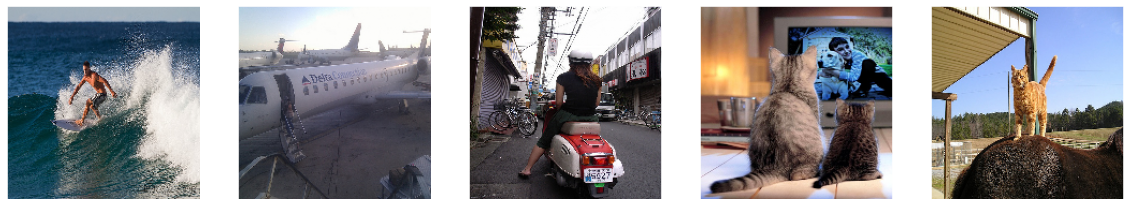

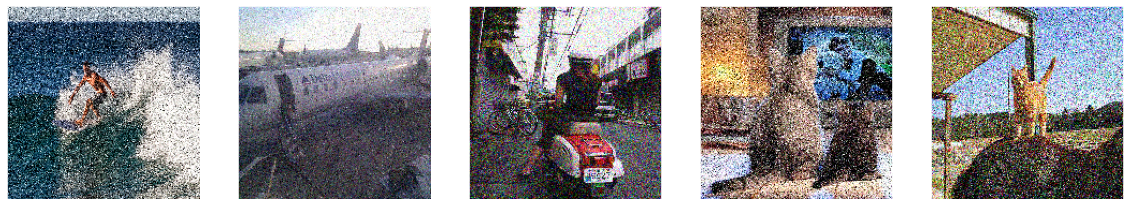

In [84]:
#Displaying images
def display_image(X, n, size = 20):
    plt.figure(figsize=(size, size))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(train,5)
display_image(train_noise, 5)

We can see below that the images from our dataset have been correctly noisy.

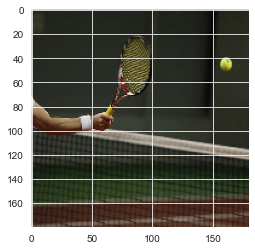

In [85]:
plt.imshow(train[50])

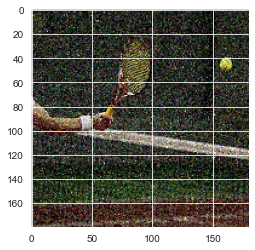

In [86]:
plt.imshow(train_noise[50])

## 6. Building our AutoEncoder

### 6.1 Overview

This AutoEncoder architecture works on the basis of 2 concepts that will allow us to take a noisy image as input:
- <strong>Encodeur</strong>: The purpose of this step is to downsample the input image. To do this, we will use convolution operations as seen previously in the first notebook. This will result in reducing the size of the input image. As a result of the convolution operations, we will obtain a vector representation of our image, called <b>latent space</b>.
<br>
- <strong>Décodeur</strong>: The second part, called decoder, takes as input the latent space generated by the encoder. Its objective will be to reconstruct the image by removing the noise. To do this, we use layers of transposed convolutions. These layers will resample the image from the latent space features as shown in the diagram below:

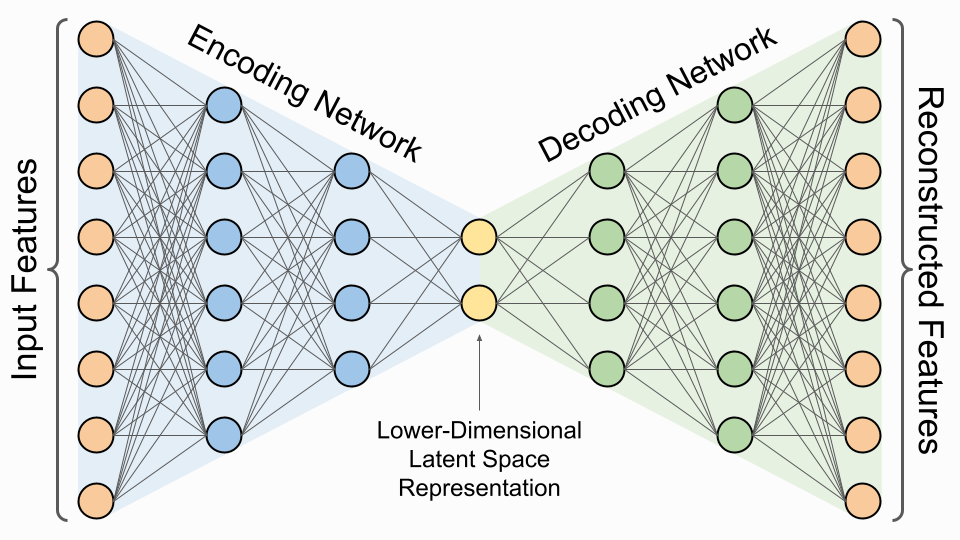
<br>



### 6.2 Implementation

In [87]:
BATCH_SIZE = 16
NUM_EPOCH = 2000
LOSS = MeanSquaredError()
OPTIMIZER = Adam(1e-3)
METRICS = [lu.SSIM]

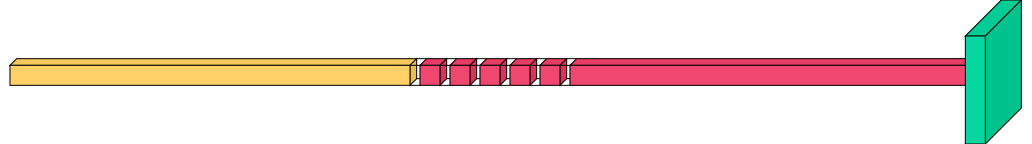

In [88]:
dnn_1 = Sequential([
    Flatten(input_shape=(IMG_H, IMG_W, 3)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=IMG_H * IMG_W * 3, activation='relu'),
    Reshape(target_shape=(IMG_H, IMG_W, 3))
], name='dnn_1')

dnn_1.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(dnn_1, scale_xy=0.6)

In [89]:
if lu.is_model_already_trained(dnn_1):
    lu.load_model_training(dnn_1)
else:
    dnn_1.fit(train_noise, train,
              batch_size=BATCH_SIZE,
              epochs= NUM_EPOCH,
              validation_data = (val_noise, val))
            
    lu.save_model_training(dnn_1)

Epoch 1/2000
83/83 [==============================] - 29s 340ms/step - loss: 0.2193 - SSIM: 0.0108 - val_loss: 0.1887 - val_SSIM: 0.0125
Epoch 2/2000
83/83 [==============================] - 32s 383ms/step - loss: 0.1682 - SSIM: 0.0146 - val_loss: 0.1623 - val_SSIM: 0.0151
Epoch 3/2000
83/83 [==============================] - 31s 370ms/step - loss: 0.1490 - SSIM: 0.0177 - val_loss: 0.1422 - val_SSIM: 0.0174
Epoch 4/2000
83/83 [==============================] - 32s 384ms/step - loss: 0.1311 - SSIM: 0.0216 - val_loss: 0.1262 - val_SSIM: 0.0224
Epoch 5/2000
83/83 [==============================] - 31s 371ms/step - loss: 0.1187 - SSIM: 0.0258 - val_loss: 0.1175 - val_SSIM: 0.0246
Epoch 6/2000
83/83 [==============================] - 31s 374ms/step - loss: 0.1112 - SSIM: 0.0289 - val_loss: 0.1110 - val_SSIM: 0.0265
Epoch 7/2000
83/83 [==============================] - 31s 377ms/step - loss: 0.1052 - SSIM: 0.0319 - val_loss: 0.1054 - val_SSIM: 0.0291
Epoch 8/2000
83/83 [=====================

83/83 [==============================] - 34s 409ms/step - loss: 0.0521 - SSIM: 0.1175 - val_loss: 0.0629 - val_SSIM: 0.0814
Epoch 61/2000
83/83 [==============================] - 33s 395ms/step - loss: 0.0517 - SSIM: 0.1190 - val_loss: 0.0613 - val_SSIM: 0.0837
Epoch 62/2000
83/83 [==============================] - 34s 408ms/step - loss: 0.0511 - SSIM: 0.1207 - val_loss: 0.0607 - val_SSIM: 0.0852
Epoch 63/2000
83/83 [==============================] - 34s 415ms/step - loss: 0.0511 - SSIM: 0.1214 - val_loss: 0.0618 - val_SSIM: 0.0836
Epoch 64/2000
83/83 [==============================] - 35s 426ms/step - loss: 0.0509 - SSIM: 0.1228 - val_loss: 0.0609 - val_SSIM: 0.0870
Epoch 65/2000
83/83 [==============================] - 34s 409ms/step - loss: 0.0503 - SSIM: 0.1246 - val_loss: 0.0609 - val_SSIM: 0.0870
Epoch 66/2000
83/83 [==============================] - 35s 426ms/step - loss: 0.0505 - SSIM: 0.1253 - val_loss: 0.0600 - val_SSIM: 0.0912
Epoch 67/2000
83/83 [===========================

KeyboardInterrupt: 

In [ ]:
lu.plot_model_history(dnn_1)

In [ ]:
img_pred = dnn_1.predict(test_noise)

In [ ]:
plt.imshow(test_noise[0])

In [ ]:
plt.imshow(img_pred[0])

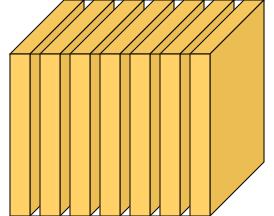

In [13]:
cnn_1 = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)), 
    ###
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    ###
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    ###
    Conv2D(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid')
], name='cnn_1')

cnn_1.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(cnn_1, scale_xy=0.9, scale_z=0.1)

In [15]:
if lu.is_model_already_trained(cnn_1):
    lu.load_model_training(cnn_1)
else:
    cnn_1.fit(train_noise, train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data = (val_noise, val))
            
    lu.save_model_training(cnn_1)

83/83 [==============================] - 121s 1s/step - loss: 0.0040 - SSIM: 0.7195 - val_loss: 0.0036 - val_SSIM: 0.7329


INFO:tensorflow:Assets written to: ram://e343e89e-e7a2-47b9-b7df-0c377c7ce517/assets


INFO:tensorflow:Assets written to: ram://e343e89e-e7a2-47b9-b7df-0c377c7ce517/assets


In [32]:
import json

cnn_1.save('test')
#

INFO:tensorflow:Assets written to: test/assets


INFO:tensorflow:Assets written to: test/assets


In [33]:
test = tf.keras.models.load_model('test', compile=False, custom_objects={"SSIM": lu.SSIM})

In [38]:
import joblib

joblib.load('models/history/cnn_1.pkl')

ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.

In [39]:
h = tf.keras.callbacks.History()
h.

In [ ]:
h.

https://stackoverflow.com/questions/67285790/keras-models-load-model-gives-valueerror

In [ ]:
lu.plot_model_history(cnn_1)

In [ ]:
cnn_1.evaluate(test_noise, test)

In [ ]:
plt.imshow(test_noise[0])

In [ ]:
preds = cnn_1.predict(test_noise)

In [ ]:
plt.imshow(preds[122])

In [ ]:
plt.imshow(test_noise[122])

In [ ]:
test[1]

In [ ]:
dn_cnn = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)),
    ####
    Conv2D(filters=3, kernel_size=(3, 3), padding='same', activation='relu'),
    ####
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    ####
    Conv2D(filters=3, kernel_size=(3, 3), padding='same'),
], name='dn_cnn')

dn_cnn.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(dn_cnn, legend=True, scale_xy=0.9, scale_z=0.1)

In [ ]:
if lu.is_model_already_trained(dn_cnn):
    lu.load_model_training(dn_cnn)
else:
    dn_cnn.fit(train_noise, train,
              epochs= NUM_EPOCH,
              validation_data = (val_noise, val))
            
    #lu.save_model_training(dn_cnn)

In [ ]:
lu.plot_model_history(dn_cnn)

https://sh-tsang.medium.com/review-dncnn-residual-learning-of-deep-cnn-image-denoising-super-resolution-jpeg-deblocking-cbf464b03130

https://github.com/wbhu/DnCNN-tensorflow/blob/master/model.py